#Demo for Monocular Depth Estimation

## Download Images and Pretrained model

If the model or image is not getting downloaded then please download it from the given google drive and upload it in the colab drive.

Links:
1. Model: https://drive.google.com/uc?id=1BP7ZS5T2k_OTW-8m6xhCwImN_X4I-JEW
2. Examples Image-1: https://drive.google.com/file/d/1-nqbmfkBDKWd237nOUzZja1qZbpkq4y6/view?usp=sharing
3. Example Image-2: https://drive.google.com/file/d/1-u4sU05lFuN5nx144AArPlLvkiw6_MhS/view?usp=sharing

Any other image can also be used

In [46]:
!gdown --id 1-u4sU05lFuN5nx144AArPlLvkiw6_MhS
!gdown --id 1-nqbmfkBDKWd237nOUzZja1qZbpkq4y6
!gdown --id 1-vWG6kkknkGm4LVmXD_aAtFlW_Hfn8hF
!gdown --id 10b70z6k2nL7nBPFrYfahYMAUvbT2z6v5

Downloading...
From: https://drive.google.com/uc?id=1-u4sU05lFuN5nx144AArPlLvkiw6_MhS
To: /content/11.jpg
100% 52.1k/52.1k [00:00<00:00, 58.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-nqbmfkBDKWd237nOUzZja1qZbpkq4y6
To: /content/illusion.jpeg
100% 88.9k/88.9k [00:00<00:00, 91.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-vWG6kkknkGm4LVmXD_aAtFlW_Hfn8hF
To: /content/NNS.jpeg
100% 93.6k/93.6k [00:00<00:00, 73.2MB/s]
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=10b70z6k2nL7nBPFrYfahYMAUvbT2z6v5 



## Import Files

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torch.nn.functional as F
import cv2

## Define and Load Model with pretrained weight in Pytorch

### Define model

In [3]:
class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.convA( torch.cat([up_x, concat_with], dim=1)  ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=1664, decoder_width = 1.0):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=0)

        self.up1 = UpSample(skip_input=features//1 + 256, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 128,  output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 64,  output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 + 64,  output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[12]
        x_d0 = self.conv2(F.relu(x_block4))

        x_d1 = self.up1(x_d0, x_block3)
        x_d2 = self.up2(x_d1, x_block2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d4 = self.up4(x_d3, x_block0)
        return self.conv3(x_d4)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        self.original_model = models.densenet169( pretrained=False )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class PTModel(nn.Module):
    def __init__(self):
        super(PTModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )


### Inititalize Weights

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
model_pytorch = PTModel()
PATH = '/content/drive/Shareddrives/CS764_Computer_Vision_Lab/Project/Models/Dense_Depth_Pretrained.pt'
model_pytorch.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Display 3D Point Cloud Image and Estimated Depth

### Display Image

(-0.5, 639.5, 479.5, -0.5)

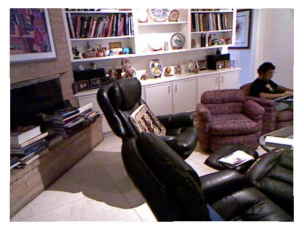

In [56]:
# Findinig Depth Map using pretrained model
with torch.no_grad():
    X = torchvision.io.read_image('/content/11.jpg').float()
    X = torchvision.transforms.Resize((480,640))(X)
    X = torch.unsqueeze(X, 0)
    Y_pred = torch.squeeze(model_pytorch(X),0)

X_dis = torch.squeeze(X, 0).numpy()
Y_pred_dis = torch.squeeze(Y_pred,0).detach().numpy()
image_dis = np.transpose(X_dis, (1,2,0)).astype('int32')
depth = 1/Y_pred_dis
plt.imshow(image_dis)
plt.axis(False)

### Displaying Depth


(-0.5, 319.5, 239.5, -0.5)

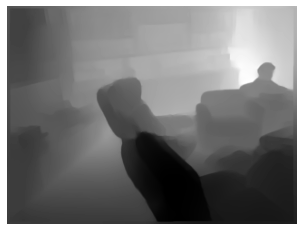

In [57]:
plt.imshow(depth, cmap = 'gray') 
plt.axis(False)

## Plot 3D Depth Map

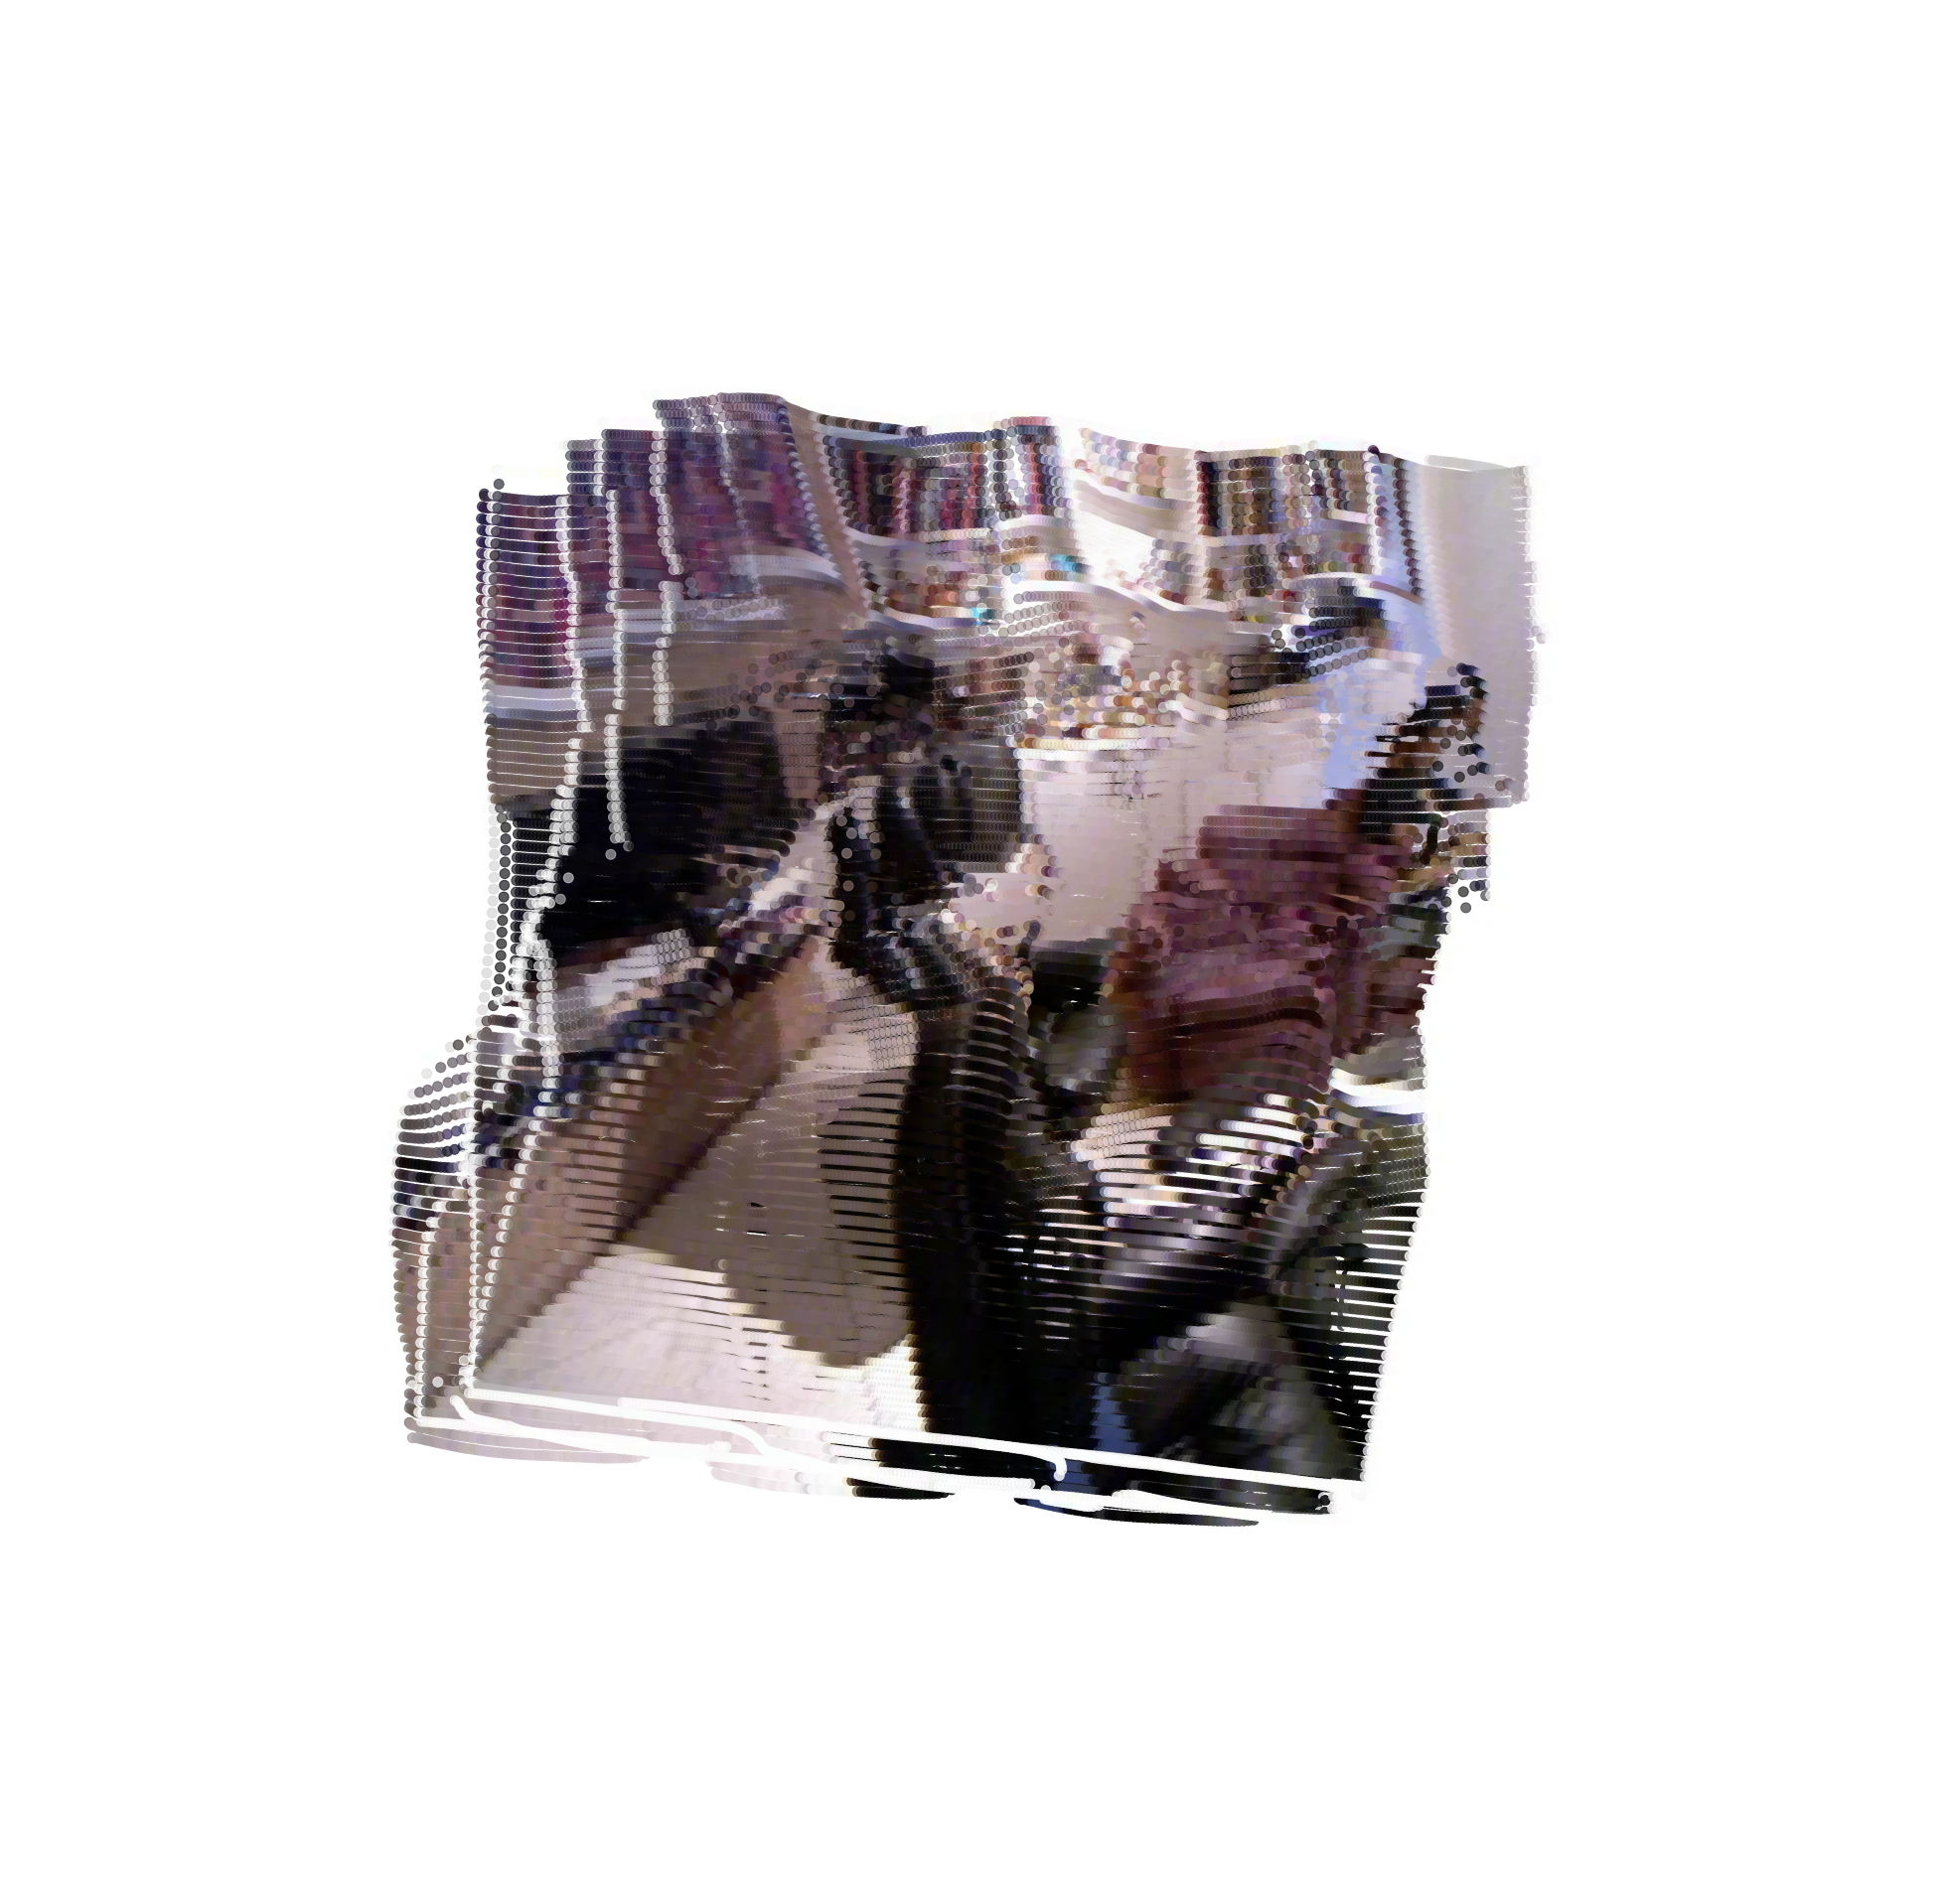

In [58]:
# Resizing Image and depth to same dimensions
image = cv2.resize(image_dis.astype('float32'), (240, 320))

(r, c, b) = np.shape(image)

# Find x, y and z coordinates
r = image.shape[0]
c = image.shape[1]
x = np.arange(0,c)
y = np.arange(0,r)
X,Y = np.meshgrid(x,y)
x = X.reshape(-1)
y = Y.reshape(-1)
z = depth.reshape(-1)

color = image.reshape(r*c, 3)
ii = np.ones_like(x).reshape(-1,1)

# Plot 3D Point Cloud
fig = plt.figure(figsize=(35.,35.))
ax = fig.add_subplot(111, projection='3d')
my_cmap = plt.get_cmap('gray')
color = color/255
color = color.tolist()

ax.scatter(-z,x,-y, color=color,marker='o', s = 100)
ax.view_init(15, 20);
ax.set_xlabel('Depth')
ax.set_ylabel('X')
ax.set_zlabel('Y')
ax.set_axis_off() 
